In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, PredictionImpossible, AlgoBase, accuracy
from surprise.prediction_algorithms import KNNBaseline, SVD
from surprise.model_selection import train_test_split
from functools import reduce
from operator import add

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
# 500_000, 100_0000, and 250_0000 gave approximately the same results
df = pd.read_csv("./data/train.csv.zip", nrows=500_000)

In [4]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,21


## Extracting ratings utility matrix from dataset

![](./assets/rating-function-explanation.png)

In [5]:
utility_matrix = df.pivot_table(
    index=["user_id"],
    columns=["hotel_cluster"],
    values=["is_booking"],
    aggfunc=lambda bookings: (5 / (1 + np.exp(-bookings.sum()))),
).rename(columns={"is_booking": "rating"})

In [6]:
utility_matrix.head()

rating                                                           \
hotel_cluster     0         1   2   3   4   5   6         7   8   9    10  11   
user_id                                                                         
12               NaN  3.655293 NaN NaN NaN NaN NaN       NaN NaN NaN  NaN NaN   
17               NaN       NaN NaN NaN NaN NaN NaN       NaN NaN NaN  2.5 NaN   
93               NaN       NaN NaN NaN NaN NaN NaN       NaN NaN NaN  NaN NaN   
190              NaN       NaN NaN NaN NaN NaN NaN  3.655293 NaN NaN  2.5 NaN   
192              NaN       NaN NaN NaN NaN NaN NaN       NaN NaN NaN  2.5 NaN   

                                                                               \
hotel_cluster  12   13  14        15        16   17   18  19  20   21  22  23   
user_id                                                                         
12            NaN  NaN NaN       NaN       NaN  NaN  NaN NaN NaN  NaN NaN NaN   
17            NaN  2.5 NaN  3.655293       NaN  NaN  2.5 NaN NaN  NaN NaN NaN   
93            NaN  NaN NaN       NaN       NaN  NaN  NaN NaN NaN  2.5 NaN NaN   
190           NaN  NaN NaN       NaN  3.655293  NaN  NaN NaN NaN  NaN NaN NaN   
192           NaN  NaN NaN       NaN       NaN  2.5  NaN NaN NaN  NaN NaN NaN   

                                                                        \
hotel_cluster   24  25  26  27   28  29   30  31   32   33  34  35  36   
user_id                                                                  
12             NaN NaN NaN NaN  NaN NaN  NaN NaN  NaN  NaN NaN NaN NaN   
17             NaN NaN NaN NaN  NaN NaN  NaN NaN  NaN  NaN NaN NaN NaN   
93             NaN NaN NaN NaN  NaN NaN  NaN NaN  NaN  NaN NaN NaN NaN   
190            NaN NaN NaN NaN  NaN NaN  2.5 NaN  NaN  NaN NaN NaN NaN   
192            2.5 NaN NaN NaN  2.5 NaN  NaN NaN  2.5  2.5 NaN NaN NaN   

                                                                            \
hotel_cluster        37  38   39  40  41        42  43  44  45  46  47  48   
user_id                                                                      
12                  NaN NaN  NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN   
17                  NaN NaN  NaN NaN NaN  2.500000 NaN NaN NaN NaN NaN NaN   
93                  NaN NaN  NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN   
190            4.403985 NaN  NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN   
192                 NaN NaN  2.5 NaN NaN  3.655293 NaN NaN NaN NaN NaN NaN   

                                                                          \
hotel_cluster   49        50   51   52  53  54   55  56  57  58   59  60   
user_id                                                                    
12             NaN       NaN  NaN  NaN NaN NaN  NaN NaN NaN NaN  NaN NaN   
17             NaN  2.500000  NaN  NaN NaN NaN  NaN NaN NaN NaN  NaN NaN   
93             NaN       NaN  NaN  NaN NaN NaN  NaN NaN NaN NaN  NaN NaN   
190            NaN       NaN  NaN  2.5 NaN NaN  NaN NaN NaN NaN  2.5 NaN   
192            2.5  3.655293  2.5  NaN NaN NaN  2.5 NaN NaN NaN  NaN NaN   

                                                                             \
hotel_cluster        61  62  63  64   65  66  67  68  69   70   71   72  73   
user_id                                                                       
12                  NaN NaN NaN NaN  NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN   
17                  NaN NaN NaN NaN  NaN NaN NaN NaN NaN  NaN  2.5  NaN NaN   
93                  NaN NaN NaN NaN  NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN   
190                 NaN NaN NaN NaN  NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN   
192            3.655293 NaN NaN NaN  2.5 NaN NaN NaN NaN  2.5  NaN  2.5 NaN   

                                                                            \
hotel_cluster  74        75  76   77  78   79   80  81  82  83  84  85  86   
user_id                                                                      
12            NaN     

In [7]:
utility_matrix.describe()

rating                                         \
hotel_cluster           0            1            2            3    
count          1943.000000  1485.000000  2440.000000  1654.000000   
mean              2.635949     2.845658     2.784320     2.601500   
std               0.395449     0.608599     0.565412     0.345108   
min               2.500000     2.500000     2.500000     2.500000   
25%               2.500000     2.500000     2.500000     2.500000   
50%               2.500000     2.500000     2.500000     2.500000   
75%               2.500000     3.655293     2.500000     2.500000   
max               4.910069     4.999969     4.998323     4.910069   

                                                                   \
hotel_cluster           4            5            6            7    
count          2220.000000  3389.000000  2490.000000  1633.000000   
mean              2.724642     2.669568     2.744396     2.797692   
std               0.501004     0.455983     0.531815     0.573684   
min               2.500000     2.500000     2.500000     2.500000   
25%               2.500000     2.500000     2.500000     2.500000   
50%               2.500000     2.500000     2.500000     2.500000   
75%               2.500000     2.500000     2.500000     2.500000   
max               4.966536     5.000000     5.000000     4.999383   

                                                                   \
hotel_cluster           8            9            10           11   
count          1551.000000  2753.000000  2425.000000  2089.000000   
mean              2.689651     2.738562     2.673984     2.697261   
std               0.476453     0.520081     0.450065     0.492572   
min               2.500000     2.500000     2.500000     2.500000   
25%               2.500000     2.500000     2.500000     2.500000   
50%               2.500000     2.500000     2.500000     2.500000   
75%               2.500000     2.500000     2.500000     2.500000   
max               4.998323     4.966536     5.000000     4.998323   

                                                                   \
hotel_cluster           12           13           14           15   
count          1064.000000  2073.000000  1453.000000  2004.000000   
mean              2.677108     2.801623     2.651296     2.779011   
std               0.470913     0.572891     0.424017     0.547242   
min               2.500000     2.500000     2.500000     2.500000   
25%               2.500000     2.500000     2.500000     2.500000   
50%               2.500000     2.500000     2.500000     2.500000   
75%               2.500000     2.500000     2.500000     2.500000   
max               5.000000     4.999773     4.966536     4.998323   

                                                                   \
hotel_cluster           16           17           18           19   
count          2748.000000  2228.000000  3000.000000  1710.000000   
mean              2.789719     2.626849     2.775762     2.783287   
std               0.572140     0.387789     0.563296     0.547420   
min               2.500000     2.500000     2.500000     2.500000   
25%               2.500000     2.500000     2.500000     2.500000   
50%               2.500000     2.500000     2.500000     2.500000   
75%               2.500000     2.500000     2.500000     2.500000   
max               4.987637     4.910069     4.999969     4.999773   

                                                                               \
hotel_cluster           20           21           22           23          24   
count          2035.000000  3115.000000  1575.000000  1537.000000  742.000000   
mean              2.601442     2.739456     2.739655     2.624331    2.746841   
std               0.355816     0.531512     0.518527     0.396442    0.538614   
min               2.500000     2.500000     2.500000     2.500000    2.500000   
25%               2.500000     2.500000     2.500000     2.500000    2.500000  

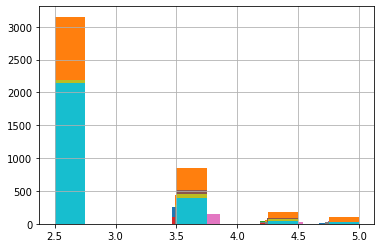

In [8]:
for column in utility_matrix.columns:
    utility_matrix[column].hist()

In [9]:
hotel_cluset_to_user_id_nan_count = (
    utility_matrix.isna().sum().to_frame("hotel_clutser-user_id NaN count")
)
hotel_cluset_to_user_id_nan_count_mean = hotel_cluset_to_user_id_nan_count.mean()
print(
    hotel_cluset_to_user_id_nan_count_mean,
    utility_matrix.shape[0],
    hotel_cluset_to_user_id_nan_count_mean / utility_matrix.shape[0],
)
hotel_cluset_to_user_id_nan_count

hotel_clutser-user_id NaN count    14541.13
dtype: float64 16543 hotel_clutser-user_id NaN count    0.87899
dtype: float64


hotel_clutser-user_id NaN count
       hotel_cluster                                 
rating 0                                        14600
       1                                        15058
       2                                        14103
       3                                        14889
       4                                        14323
...                                               ...
       95                                       13804
       96                                       14469
       97                                       14280
       98                                       13814
       99                                       13937

[100 rows x 1 columns]

In [10]:
user_id_to_hotel_cluster_nan_count = (
    utility_matrix.transpose().isna().sum().to_frame("user_id-hotel_cluster NaN count")
)
print(
    user_id_to_hotel_cluster_nan_count.mean(),
    utility_matrix.shape[1],
)
user_id_to_hotel_cluster_nan_count

user_id-hotel_cluster NaN count    87.898991
dtype: float64 100


,user_id-hotel_cluster NaN count
user_id,
12,99
17,91
93,97
190,90
192,78
...,...
1198195,80
1198524,93
1198619,90


## Building the dataset

In [11]:
surprise_df = utility_matrix.reset_index().set_index(["user_id"]).stack().reset_index()
surprise_df
# Notice the deletion of NaN ratings

,user_id,hotel_cluster,rating
0,12,1,3.655293
1,17,10,2.500000
2,17,13,2.500000
3,17,15,3.655293
4,17,18,2.500000
...,...,...,...
200182,1198634,91,4.403985
200183,1198784,26,2.500000
200184,1198784,68,2.500000
200185,1198784,79,3.655293


In [12]:
dataset = Dataset.load_from_df(surprise_df, reader=Reader(rating_scale=(1, 5)))
trainset, testset = train_test_split(dataset, test_size=0.25)

## Collaborative item-to-item filtering model with KNNBaseline

In [13]:
KNNBaseline_algo = KNNBaseline(sim_options={"name": "cosine", "user_based": False})
KNNBaseline_algo.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


## Latent factor model with SVD

In [14]:
SVD_algo = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
SVD_algo.fit(trainset)

## Content-based model

### Building items profiles

In [15]:
dests_df = pd.read_csv("./data/destinations.csv.zip").set_index("srch_destination_id")

- `srch_destination_id` is the destination of the desired hotel specified by the user via the search event. Example of such a destination is "New York City".
- Aspect-based sentiment analysis was conducted on the text reviews of the hotels of each destination considering aspects such as the beach, ski, etc., and the results were encoded as the latent features d1-d149.
- Those features could serve as the item profile of each hotel cluster.
- But the problem is that a hotel cluster can belong to multiple destinations. e.g: "New York and vicinity", "New York City".
- To solve this, we say that a hotel cluster profile is the average vector of all the d1-d149 vectors of the destinations that hotel is associated with via search events.

In [16]:
dests_df

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
srch_destination_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.043789,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,-2.224164,-2.209855,-2.224164,-2.110723,-2.186008,-2.224164,-2.124474,-2.224164,-2.156467,-2.224164,-2.224164,-2.2241

In [17]:
hotel_cluster_and_dests_df = df.set_index("hotel_cluster")[
    ["srch_destination_id"]
].drop_duplicates()

In [18]:
hotel_cluster_and_dests_df

,srch_destination_id
hotel_cluster,
1,8250
80,14984
41,8267
18,8291
16,12193
...,...
91,4689
20,8162
62,33483


In [19]:
def aggregate_hotel_profile(dests_ids):
    try:
        return dests_df.loc[dests_ids].mean().to_list()
    except KeyError:
        """
        This is necessary since some destinations associated with a hotel cluster do not exist in the destinations.csv file, because
        those hotels are new and don't have enough reviews to produce significant features in the latent space.
        """
        return dests_df.mean().to_list()


hotel_cluster_to_profile_df = hotel_cluster_and_dests_df.groupby("hotel_cluster").agg(
    {"srch_destination_id": aggregate_hotel_profile}
).rename(columns={ "srch_destination_id": "hotel_profile" })

In [20]:
hotel_cluster_to_profile_df

,hotel_profile
hotel_cluster,
0,"[-2.1939032318063623, -2.2028544362513682, -2...."
1,"[-2.2222312557333335, -2.287469787915, -2.3686..."
2,"[-2.1939032318063623, -2.2028544362513682, -2...."
3,"[-2.1939032318063623, -2.2028544362513682, -2...."
4,"[-2.1939032318063623, -2.2028544362513682, -2...."
...,...
95,"[-2.234769252447193, -2.212490626760702, -2.27..."
96,"[-2.1939032318063623, -2.2028544362513682, -2...."
97,"[-2.1939032318063623, -2.2028544362513682, -2...."


In [22]:
hotel_cluster_to_profile_mapping = hotel_cluster_to_profile_df.to_dict()[
    "hotel_profile"
]

In [23]:
hotel_cluster_to_profile_mapping

{0: [-2.1939032318063623,
  -2.2028544362513682,
  -2.207390548768163,
  -2.194039670544925,
  -2.1614965229729184,
  -2.0451102954190694,
  -2.20243309949974,
  -2.2032072931396796,
  -2.107808143808767,
  -2.193154724812071,
  -2.1659442628545684,
  -2.2089093829918727,
  -2.172785667049823,
  -2.1368632431626557,
  -2.209442708182053,
  -2.095220641259547,
  -2.184252104255707,
  -2.2004449538973363,
  -2.206564107834628,
  -2.1889677750641607,
  -2.1984155502017035,
  -2.201022065545364,
  -2.2092244008807875,
  -2.2012347784978923,
  -2.2060969051392063,
  -2.202669652123198,
  -2.188562933798638,
  -2.2056993547689543,
  -2.1088191170940442,
  -2.1951739900453133,
  -2.208795028072862,
  -2.2017364090260068,
  -2.206095900649009,
  -2.1872731775458427,
  -2.1883850803534637,
  -2.2046245919366245,
  -1.8830172846095217,
  -2.198458659217939,
  -2.206226957897897,
  -2.2056504098951617,
  -2.1814364409903457,
  -2.204144836629978,
  -2.053775856298832,
  -2.193348028857714,
  -2.1

### Implementing content-based filtering

![](./assets/similarity-to-rating-function.png)

In [24]:
class ContentBased(AlgoBase):
    def __init__(self, items_profiles):
        AlgoBase.__init__(self)
        self.items_profiles = items_profiles

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        self.users_profiles = {
            trainset.to_raw_uid(user): np.mean(
                [
                    np.dot(self.items_profiles[trainset.to_raw_iid(item)], rating)
                    for (item, rating) in trainset.ur[user]
                ],
                axis=0,
            )
            for user in trainset.all_users()
        }

        return self

    def get_rating_from_cos_sim(self, cos_sim):
        squeezed_sim = cos_sim / 2 + 0.5  # [0, 1]
        one_to_four_scale = squeezed_sim * 4  # [0, 4]
        shifted_by_one_scale = one_to_four_scale + 1  # [1, 5]
        return shifted_by_one_scale

    def estimate(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")

        user_profile, item_profile = (
            self.users_profiles[self.trainset.to_raw_uid(u)],
            self.items_profiles[self.trainset.to_raw_iid(i)],
        )

        user_profile = user_profile - np.mean(user_profile)
        item_profile = item_profile - np.mean(item_profile)

        cos_sim = np.dot(user_profile, item_profile) / (
            np.linalg.norm(user_profile) * np.linalg.norm(item_profile)
        )

        return self.get_rating_from_cos_sim(cos_sim)

### Building the content-based model

In [25]:
ContentBased_algo = ContentBased(items_profiles=hotel_cluster_to_profile_mapping)
ContentBased_algo.fit(trainset)

## Comparison between the 3 models

In [26]:
def precision_at_k(predictions, k=5, threshold=2.5):
    def append_user_ratings(users_precisions, prediction):
        user, _, true_rating, prediction, _ = prediction
        users_precisions[user] = users_precisions.get(user, []) + [
            (true_rating, prediction)
        ]
        return users_precisions

    users_ratings = reduce(append_user_ratings, predictions, {})

    def compute_user_precision(users_precisions, user_ratings):
        user_ratings[1].sort(key=lambda rating: rating[1], reverse=True)

        recommended_in_k_count = sum(
            (prediction >= threshold) for (prediction, _) in user_ratings[1][:k]
        )
        recommended_and_relevant_in_k_count = sum(
            ((true_rating >= threshold) and (prediction >= threshold))
            for (prediction, true_rating) in user_ratings[1][:k]
        )

        users_precisions[user_ratings[0]] = (
            0
            if recommended_in_k_count == 0
            else recommended_and_relevant_in_k_count / recommended_in_k_count
        )

        return users_precisions

    users_precisions = reduce(compute_user_precision, users_ratings.items(), {})

    return users_precisions

In [27]:
for key, algo in {
    "KNNBaseline": KNNBaseline_algo,
    "SVD": SVD_algo,
    "ContentBased": ContentBased_algo,
}.items():
    predictions = algo.test(testset)

    top_k = 5
    users_precisions = precision_at_k(predictions, k=top_k)
    avg_precision = reduce(add, users_precisions.values()) / len(users_precisions)

    RMSE = accuracy.rmse(predictions, verbose=False)

    harmonic_mean_weight = 0.35  # favoring RMSE over Precision
    harmonic_mean = 1 / (
        harmonic_mean_weight * (1 / avg_precision) + (1 - harmonic_mean_weight) * RMSE
    )

    print(
        f"""{key}:
    * RMSE => \033[93m{RMSE}\033[0m.
    * Precesion@{top_k} => \033[93m{avg_precision}\033[0m.
    * Weighted Harmonic Mean with alpha = 0.35 favoring RMSE => \033[93m{harmonic_mean}\033[0m."""
    )

KNNBaseline:
    * RMSE => 0.48883658916459133.
    * Precesion@5 => 0.8167064587530165.
    * Weighted Harmonic Mean with alpha = 0.35 favoring RMSE => 1.339953901917136.
SVD:
    * RMSE => 0.4747238880221963.
    * Precesion@5 => 0.9715324927255101.
    * Weighted Harmonic Mean with alpha = 0.35 favoring RMSE => 1.4951569500073751.
ContentBased:
    * RMSE => 2.2959805551141157.
    * Precesion@5 => 1.0.
    * Weighted Harmonic Mean with alpha = 0.35 favoring RMSE => 0.5427740231308681.


## Submission to Kaggle

In [28]:
test_df = pd.read_csv("./data/test.csv.zip")

In [29]:
test_df.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,0,3,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,0,10,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,0,1,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,1,10,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,0,0,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


In [ ]:
def recommend_for_user_at(idx):
    user_id = test_df.loc[idx, ["user_id"]].values[0]

    predictions = []
    for hotel_cluster in trainset.all_items():
        _, _, _, prediction, _ = SVD_algo.predict(uid=user_id, iid=hotel_cluster)
        predictions.append((hotel_cluster, prediction))

    return " ".join(
        list(
            map(
                lambda prediction: f"{prediction[0]}",
                sorted(predictions, key=lambda x: x[1], reverse=True)[:5],
            )
        )
    )


submission_df = pd.DataFrame(
    columns=["id", "hotel_cluster"],
    data={
        "id": test_df["id"],
        "hotel_cluster": [recommend_for_user_at(idx) for idx in test_df.index],
    },
)

In [ ]:
submission_df.to_csv("./output/submission.csv", index=False)